> Igor Sorochan DSU-31

# Search for outliers and new features generation

## Glass Classification



Data exploration of this dataset reveals two important characteristics :
1. The variables are highly corelated with each other including the response variables:  
So which kind of ML algorithm is most suitable for this dataset Random Forest , KNN or other?  
Also since dataset is too small is there any chance of applying PCA or it should be completely avoided?

2. Highly Skewed Data:
Is scaling sufficient or are there any other techniques which should be applied to normalize data?  
Like BOX-COX Power transformation?

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

In [240]:
data = pd.read_csv('https://drive.google.com/uc?id=1foxOjvDVVdzJ1hmoOOd6J2rSFxv7cZ9V')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Type of glass: (class attribute)  

1. building_windows_float_processed
2. building_windows_non_float_processed
3. vehicle_windows_float_processed
4. vehicle_windows_non_float_processed (none in this database)
5. containers
6. tableware
7. headlamps

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [242]:
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### Basic cleaning

#### Duplicates

In [243]:
if data.duplicated().sum():
    print('Duplicated rows to be dropped:')
    display(data[data.duplicated()])
    data.drop_duplicates(inplace=True)

Duplicated rows to be dropped:


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


#### Missing values

In [244]:
data.isna().sum().any()

False

In [245]:
labels = data.Type.value_counts().sort_index(ascending=True).index # get the labels of the target variable (Type)
print(f'Target variable values: {", ".join(labels.values.astype(str))}')
cols = data.columns[0:-1]   # get the columns
X = data[cols]              # get the features
y = data['Type']            # get the target

Target variable values: 1, 2, 3, 5, 6, 7


### Visualization of feature distribution

#### Visuals with pyplot

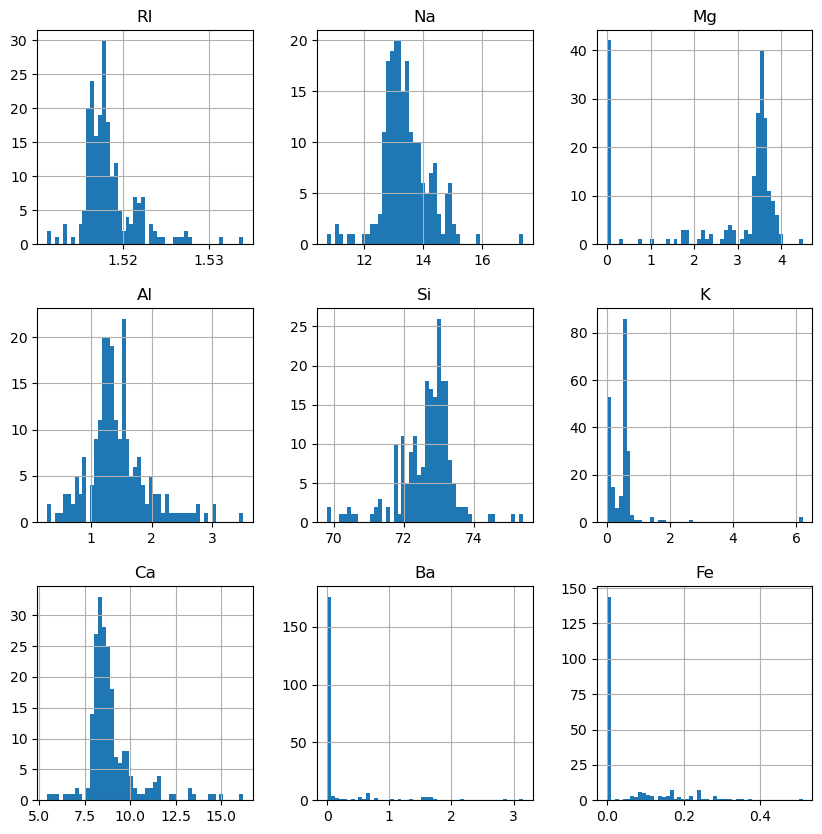

In [246]:
X.hist(figsize=(10,10), bins=50);

Almost every feature has outliers and non normal distribution.

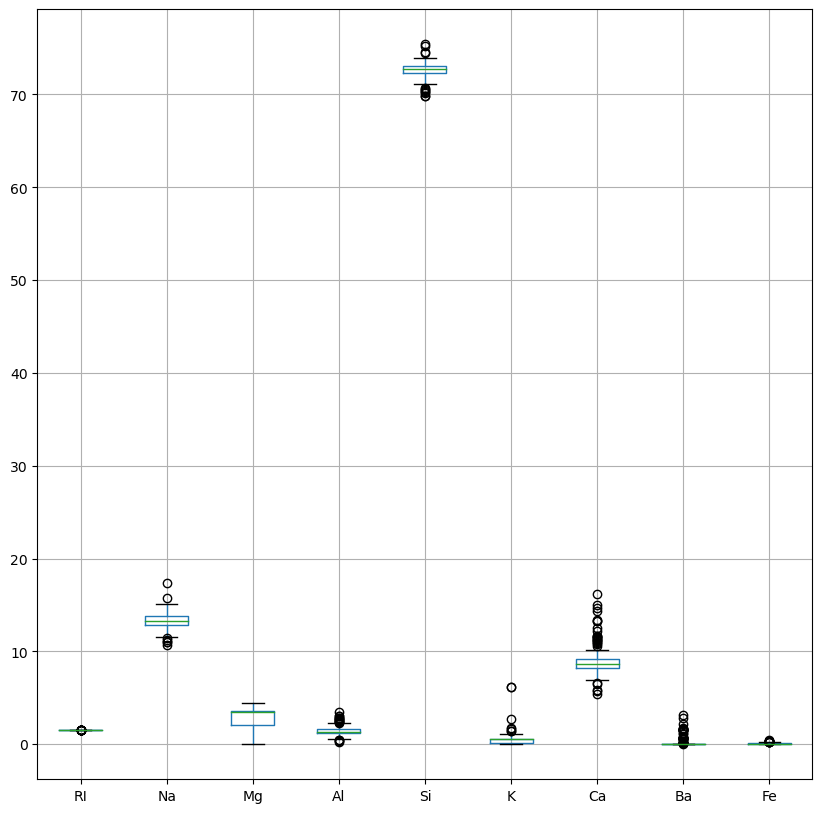

In [247]:
X.boxplot(figsize=(10,10));

This plot is not easy to evaluate due to difference in scales.

#### The distribution of target value (Type of glass)

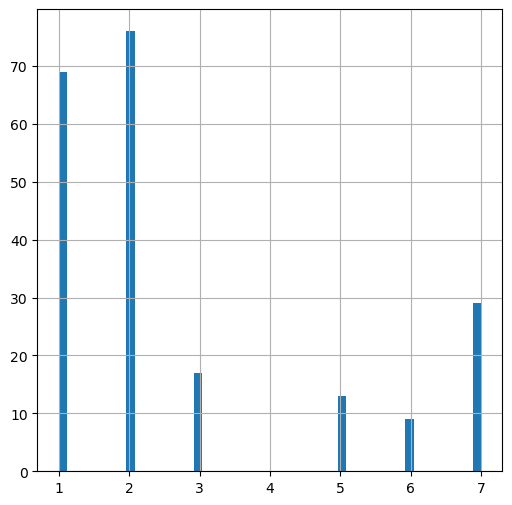

In [248]:
y.hist(figsize=(6,6), bins=50);

Target values are not balanced.  
We will use SMOTE to balance the dataset.

#### Visuals with Seaborn

##### Features distribution

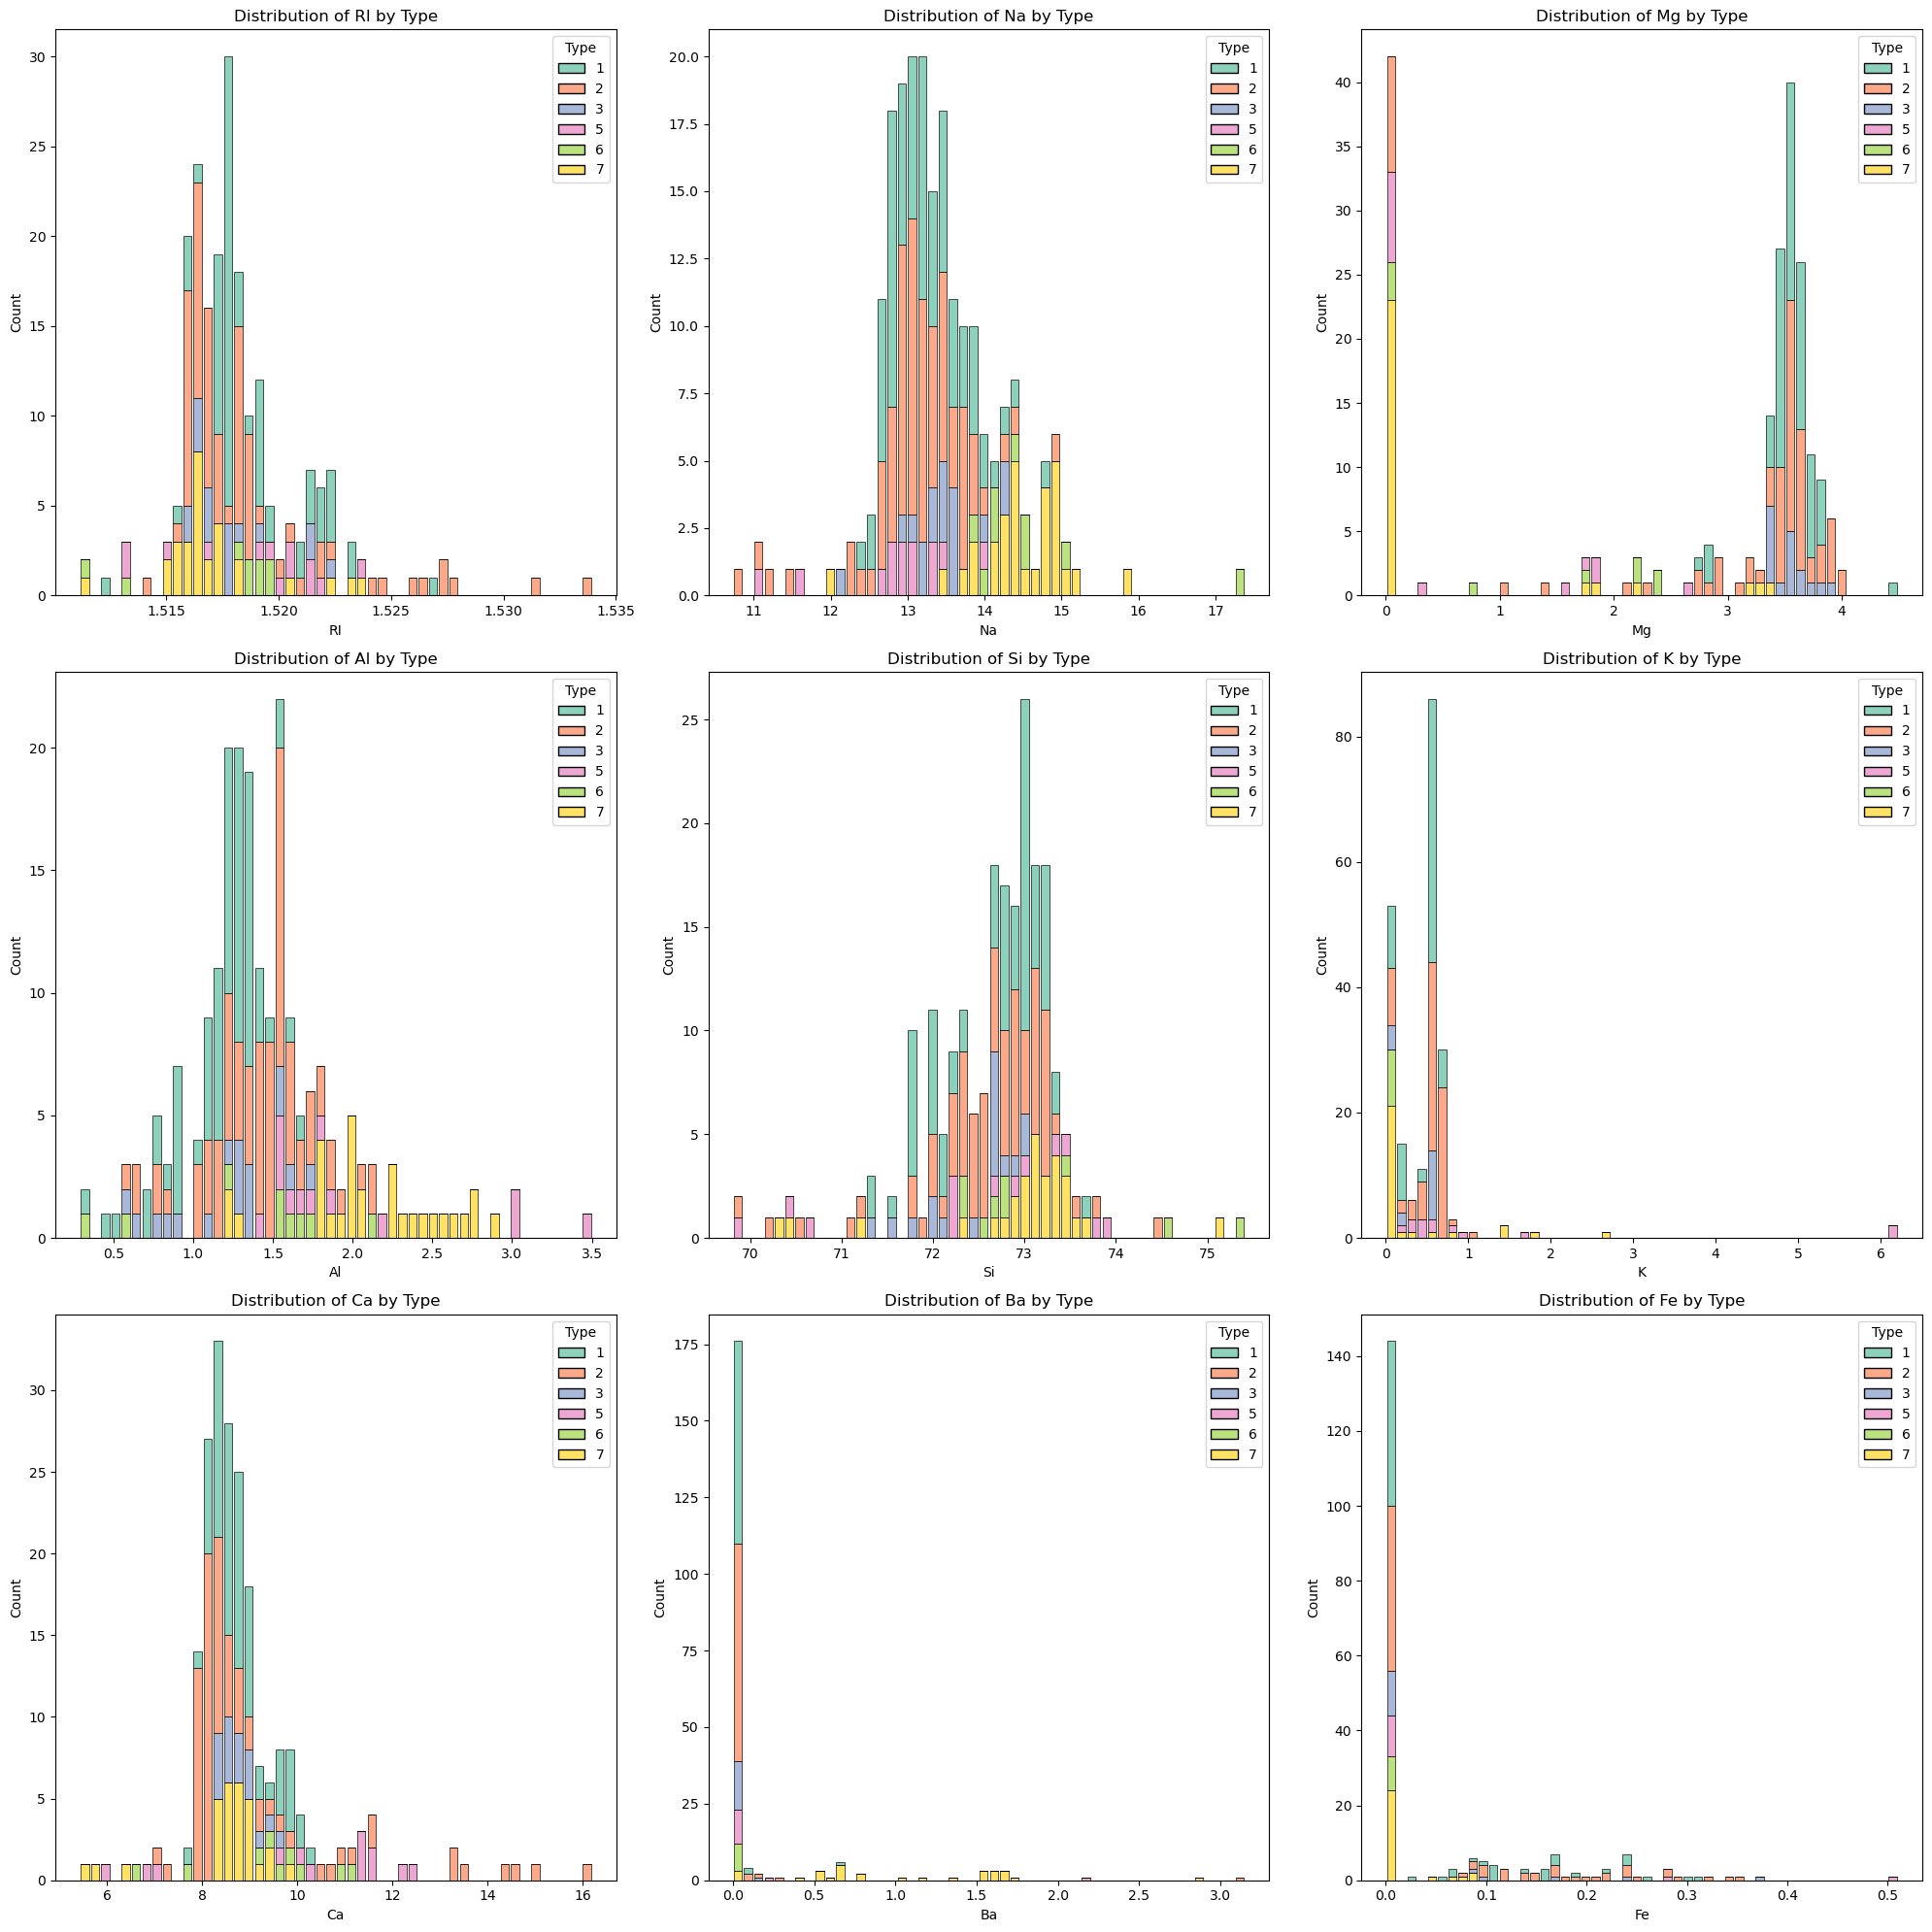

In [249]:
f, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=False)
for i, ax in enumerate(axes.flatten()):
    if i < len(cols):
        sns.histplot( x=X.iloc[:, i], ax=ax, kde= False,  bins=50,  hue= y, palette='Set2',multiple="stack", shrink=.8)
        ax.set_title(f'Distribution of {cols[i]} by Type')

plt.tight_layout()
plt.show()

 Boxplot gives visual perception with focus on outliers:

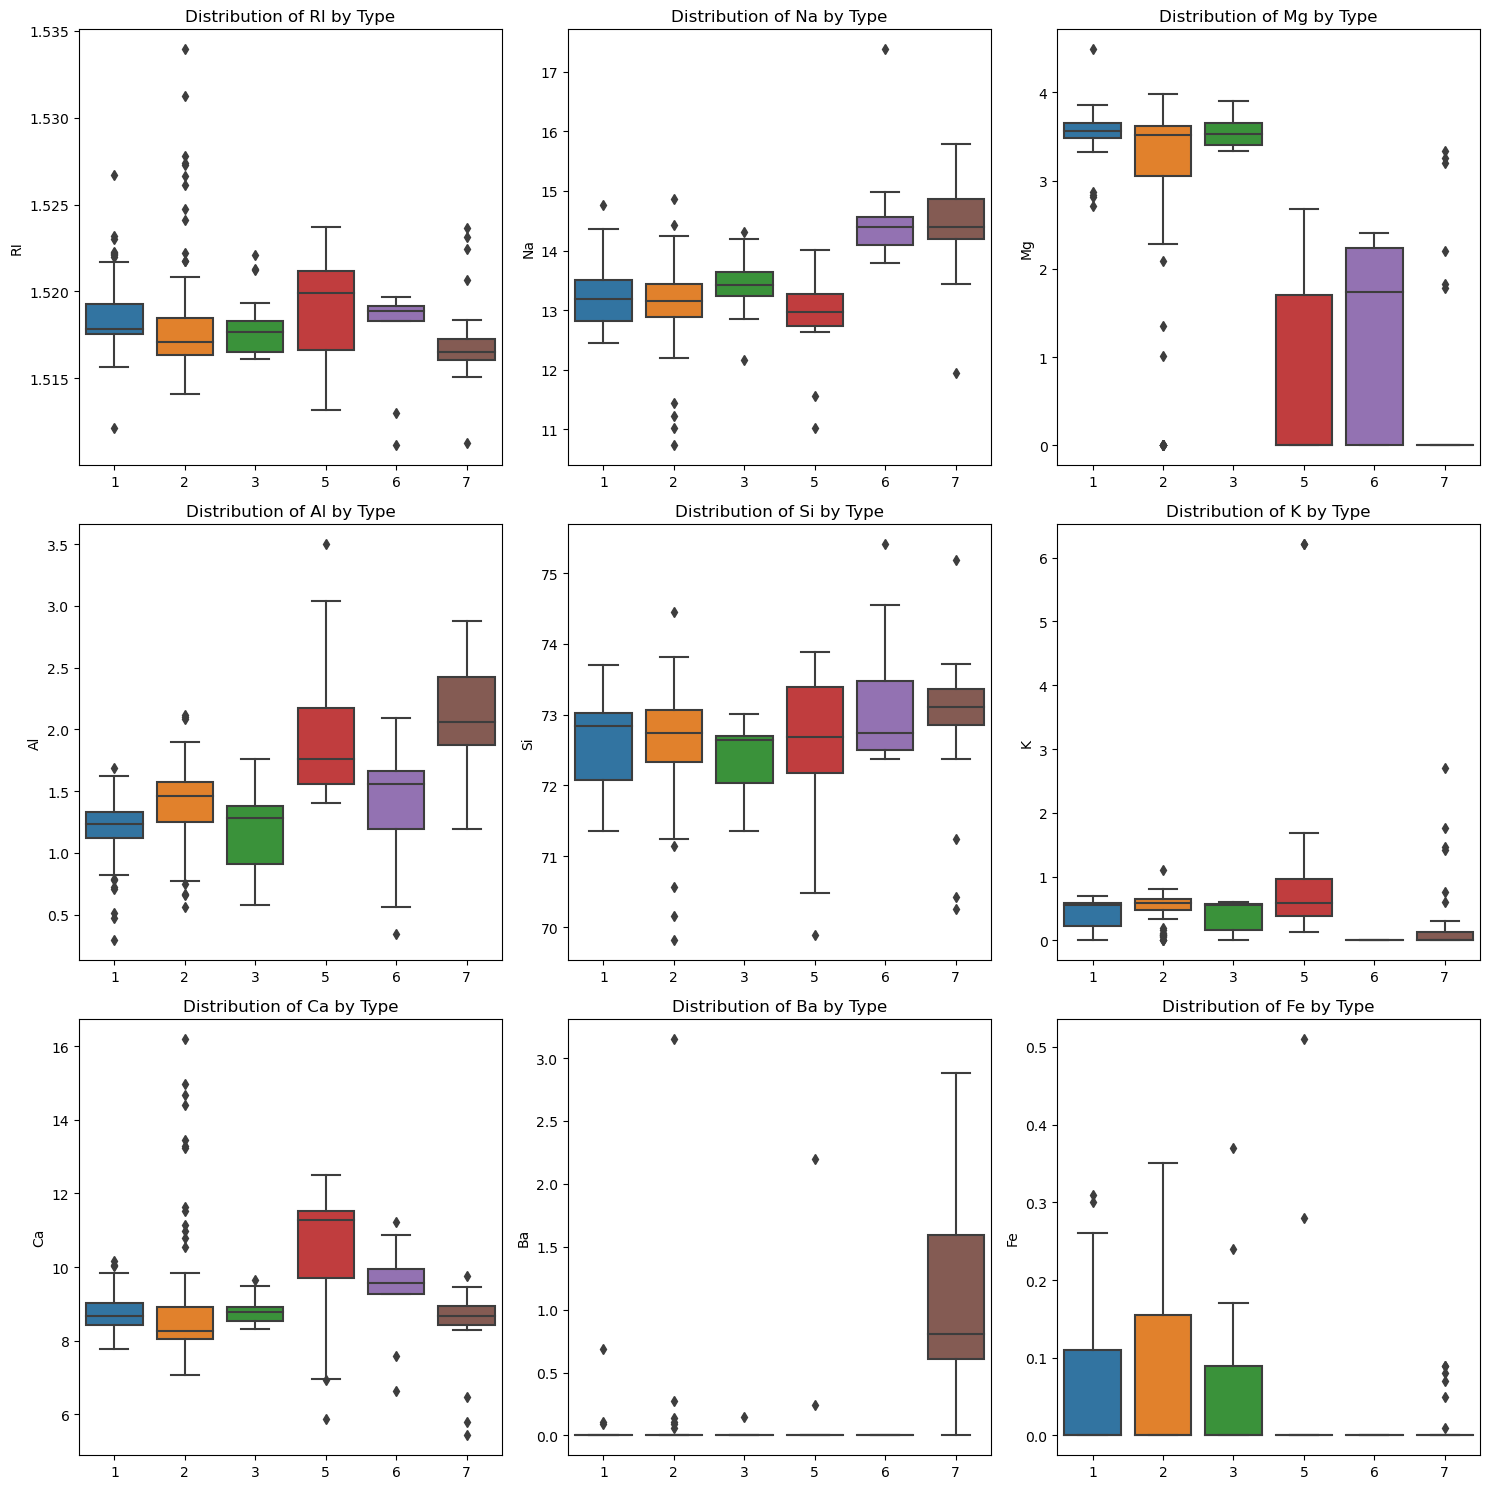

In [250]:
f, axes = plt.subplots(3,3 , figsize=(15, 15), sharex=False)
for i, ax in enumerate(axes.flatten()):
    if i <= len(cols):
        sns.boxplot(x= y, y=X.iloc[:, i], ax=ax)
        ax.set_title(f'Distribution of {cols[i]} by Type')
        ax.set(xlabel=None)
plt.tight_layout() 
plt.show()

Almost every feature has outliers.  
In addition, "Type" (target variable) affects the number of outliers.  
The issue here is with a very small data set.  
Removing even one observation can reduce the power of the model.

### Process

#### Detection of outliers

Let's use Isolation Forest for outliers detection.

#### Isolation forest

In [251]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.08, max_features=1.0, 
                      bootstrap= True, n_jobs=-1, random_state=42, warm_start= False)  # create the model
clf.fit(X.values)                                                   # fit the model
outl = (clf.decision_function(X.values)<0).sum()                    # get the number of detected outliers
X['anomaly'] = clf.predict(X.values)                                # put the anomaly prediction in a new column         

display(X.anomaly.value_counts())
print(f'IsolationForest select {outl} observations as outliers.')

 1    196
-1     17
Name: anomaly, dtype: int64

IsolationForest select 17 observations as outliers.


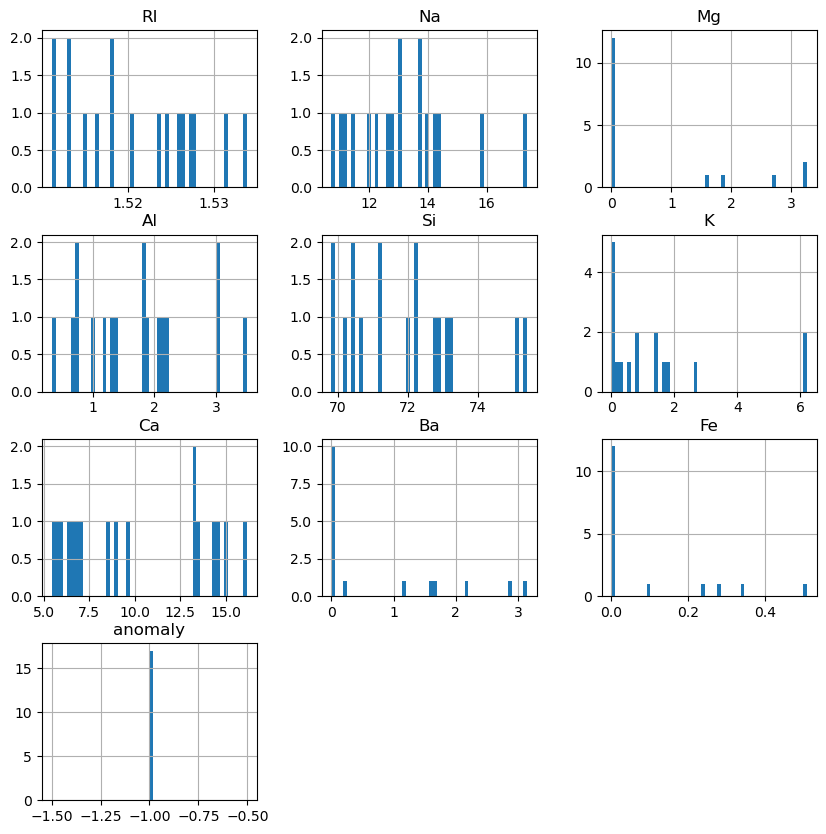

In [252]:
X[X.anomaly != 1].hist(figsize=(10,10), bins=50);

In [253]:
results = {}

### Analysis

#### Random forest

In [254]:
X_train, X_test_MAIN, y_train, y_test_MAIN = train_test_split(X.drop('anomaly', axis= 1), y, test_size=0.2, random_state=42)
# fix test set for later use as _MAIN

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
results['RFC'] = rfc.score(X_test_MAIN, y_test_MAIN)
rfc.score(X_train, y_train), rfc.score(X_test_MAIN, y_test_MAIN)

(1.0, 0.7674418604651163)

Model is overfitted.

In [255]:
pred = rfc.predict(X_test_MAIN)
rep1 = classification_report(y_test_MAIN, pred, digits= 4, output_dict= False)
print(rep1)

              precision    recall  f1-score   support

           1     0.7143    1.0000    0.8333        10
           2     0.6667    0.6667    0.6667        15
           3     1.0000    0.6667    0.8000         3
           5     0.5000    0.3333    0.4000         3
           6     1.0000    0.6667    0.8000         3
           7     1.0000    0.8889    0.9412         9

    accuracy                         0.7674        43
   macro avg     0.8135    0.7037    0.7402        43
weighted avg     0.7824    0.7674    0.7629        43



0.74 is the average of the precision/recall for each class (macro avg).  
We see a poor performance on the 5-th class.

####  Repeat on X without outliers.  
Fit on cropped data set. Test on MAIN test set.

In [256]:
ind = X[X.anomaly == 1].index   # get the index of the normal data
print(f'Cropped data set has {len(ind)} observations.')
X_train, X_test, y_train, y_test = train_test_split(X.loc[ind, :].drop('anomaly', axis= 1), y[ind], test_size=0.2, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

pred = rfc.predict(X_test_MAIN)    # predict the previous test set (with outliers)

rep2 = classification_report(y_test_MAIN, pred, digits= 4, output_dict= False)
results['RFC w/o outliers'] = rfc.score(X_test_MAIN, y_test_MAIN)
print(rep2)

Cropped data set has 196 observations.
              precision    recall  f1-score   support

           1     0.8333    1.0000    0.9091        10
           2     0.8667    0.8667    0.8667        15
           3     1.0000    0.6667    0.8000         3
           5     0.3333    0.3333    0.3333         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    0.8889    0.9412         9

    accuracy                         0.8605        43
   macro avg     0.8389    0.7926    0.8084        43
weighted avg     0.8682    0.8605    0.8596        43



We managed to improve f1-score on MAIN test set from 0.74 to 0.79.  
Not bad.

Let' calculate the relative normality of features. 

In [257]:
X.loc[ind, :].shape[0]/X.shape[0]

0.92018779342723

#### Let's enhance the RFC with SMOTE.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular algorithm used in machine learning  
for handling imbalanced datasets.  
It works by generating synthetic samples of the minority class 
by interpolating between existing minority class samples.

In [258]:
try:
  from imblearn.over_sampling import SMOTE
except:
  !pip install imblearn
  from imblearn.over_sampling import SMOTE

In [259]:
?smote

Type:        SMOTE
String form: SMOTE(k_neighbors=3, random_state=42)
File:        ~/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py
Docstring:  
Class to perform over-sampling using SMOTE.

This object is an implementation of SMOTE - Synthetic Minority
Over-sampling Technique as presented in [1]_.

Read more in the :ref:`User Guide <smote_adasyn>`.

Parameters
----------
sampling_strategy : float, str, dict or callable, default='auto'
    Sampling information to resample the data set.

    - When ``float``, it corresponds to the desired ratio of the number of
      samples in the minority class over the number of samples in the
      majority class after resampling. Therefore, the ratio is expressed as
      :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
      number of samples in the minority class after resampling and
      :math:`N_{M}` is the number of samples in the majority class.

        .. warning::
           ``float`` is onl

In [260]:
smote = SMOTE(random_state=42,  k_neighbors= 3)
print(f'Original X shape: {X.drop("anomaly", axis= 1).shape}\n')
# split  original X and y
X_resampled, y_resampled = smote.fit_resample(X.drop('anomaly', axis= 1), y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test_MAIN)

rep3 = classification_report(y_test_MAIN, pred, digits= 4, output_dict= False)
results['RFC_SMOTE'] = rfc.score(X_test_MAIN, y_test_MAIN)
print(rep3)

Original X shape: (213, 9)

              precision    recall  f1-score   support

           1     0.9000    0.9000    0.9000        10
           2     0.9333    0.9333    0.9333        15
           3     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    1.0000    1.0000         9

    accuracy                         0.9535        43
   macro avg     0.9722    0.9722    0.9722        43
weighted avg     0.9535    0.9535    0.9535        43



The leverage of SMOTE improves macro avg from 0.74 to 0.97.  
It's a significant improvement over RFC "out of the box" usage.

#### Let's combine SMOTE with dropping outliers.

In [261]:
smote = SMOTE(random_state= 42, k_neighbors= 3)
# split X and y without outliers
print(f'X without outliers shape: {X.loc[ind, :].drop("anomaly", axis= 1).shape}\n')
X_resampled, y_resampled = smote.fit_resample(X.loc[ind, :].drop('anomaly', axis= 1), y[ind])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test_MAIN)

rep4 = classification_report(y_test_MAIN, pred, digits= 4, output_dict= False)
results['RFC_SMOTE w/o outliers'] = rfc.score(X_test_MAIN, y_test_MAIN)
print(rep4)

X without outliers shape: (196, 9)

              precision    recall  f1-score   support

           1     0.9091    1.0000    0.9524        10
           2     0.9231    0.8000    0.8571        15
           3     1.0000    1.0000    1.0000         3
           5     0.5000    1.0000    0.6667         3
           6     1.0000    1.0000    1.0000         3
           7     1.0000    0.7778    0.8750         9

    accuracy                         0.8837        43
   macro avg     0.8887    0.9296    0.8919        43
weighted avg     0.9171    0.8837    0.8897        43



#### Confusion matrix based on best model

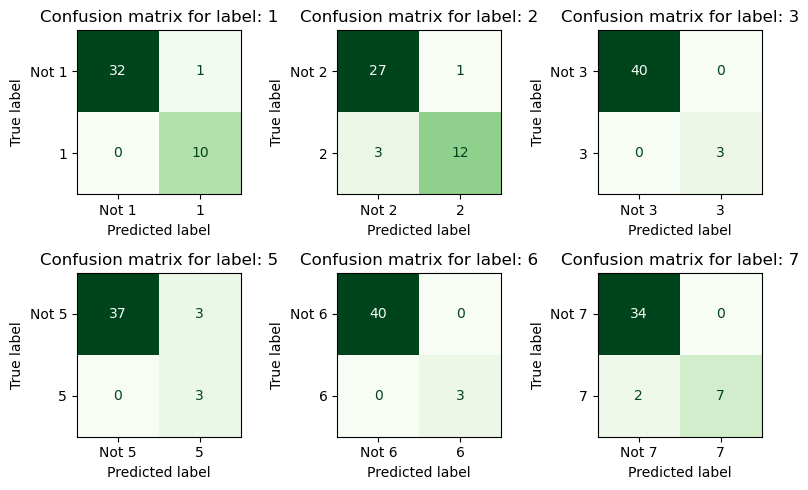

In [262]:
cm = multilabel_confusion_matrix(y_test_MAIN, pred)
fig, ax = plt.subplots(2,3, figsize=(8, 5))

for i, label in enumerate(labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[f'Not {label}',label])
    disp.plot(ax=ax[i//3, i%3 ],  cmap='Greens', colorbar= False)
    disp.ax_.set_title(f"Confusion matrix for label: {label}")
plt.tight_layout()
plt.show()

In [263]:
temp = pd.DataFrame(results, index=['score']).T
temp.sort_values(by='score', ascending=False).style.bar(align="mid", color = 'lightgreen', vmin=0.1, vmax=1.0)

,score
RFC_SMOTE,0.953488
RFC_SMOTE w/o outliers,0.883721
RFC w/o outliers,0.860465
RFC,0.767442


### SHARE
#### Main takeaways:

1. Removing outliers improves the power of the model
2. Leveraging SMOTE processing (addressing the imbalanced classes) with our small dataset improves the metrics greatly.
3. The slightly worse performance of of SMOTE with dropping outliers can be explained by the lack of data (only 213 observations).